In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Conv2D, Flatten

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'cnn2d_regression_model.h5'

C:\Users\psxjmma\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Data Ingestion

In [2]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('train_FD003.txt', sep=" ", header=None)


In [3]:
train_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,NaN,NaN
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,NaN,NaN
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,NaN,NaN
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,NaN,NaN
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,NaN,NaN
5,1,6,0.0011,-0.0005,100.0,518.67,642.24,1584.09,1400.01,14.62,...,8144.92,8.4152,0.03,393,2388,100.0,38.92,23.4281,NaN,NaN
6,1,7,-0.0038,0.0002,100.0,518.67,642.58,1585.61,1401.09,14.62,...,8147.05,8.3842,0.03,391,2388,100.0,38.84,23.4087,NaN,NaN
7,1,8,-0.0007,-0.0005,100.0,518.67,642.32,1588.32,1397.08,14.62,...,8157.34,8.4190,0.03,391,2388,100.0,39.05,23.4590,NaN,NaN
8,1,9,-0.0026,0.0000,100.0,518.67,641.64,1587.81,1406.51,14.62,...,8147.20,8.4091,0.03,392,2388,100.0,38.99,23.4693,NaN,NaN
9,1,10,0.0019,-0.0002,100.0,518.67,642.42,1587.39,1402.25,14.62,...,8152.86,8.3987,0.03,391,2388,100.0,38.94,23.4781,NaN,NaN


In [4]:
#remove the columns 26 and 27 because of NAN values
train_df=train_df.loc[:,0:25]

In [5]:
train_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
5,1,6,0.0011,-0.0005,100.0,518.67,642.24,1584.09,1400.01,14.62,...,522.42,2388.02,8144.92,8.4152,0.03,393,2388,100.0,38.92,23.4281
6,1,7,-0.0038,0.0002,100.0,518.67,642.58,1585.61,1401.09,14.62,...,522.46,2388.02,8147.05,8.3842,0.03,391,2388,100.0,38.84,23.4087
7,1,8,-0.0007,-0.0005,100.0,518.67,642.32,1588.32,1397.08,14.62,...,522.10,2387.97,8157.34,8.4190,0.03,391,2388,100.0,39.05,23.4590
8,1,9,-0.0026,0.0000,100.0,518.67,641.64,1587.81,1406.51,14.62,...,521.83,2388.01,8147.20,8.4091,0.03,392,2388,100.0,38.99,23.4693
9,1,10,0.0019,-0.0002,100.0,518.67,642.42,1587.39,1402.25,14.62,...,521.96,2387.99,8152.86,8.3987,0.03,391,2388,100.0,38.94,23.4781


In [6]:
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

In [7]:
train_df.tail(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753
24719,100,152,0.0000,0.0003,100.0,518.67,643.64,1599.04,1436.06,14.62,...,519.48,2388.24,8136.98,8.5150,0.03,396,2388,100.0,38.56,23.0847


In [8]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('test_FD003.txt', sep=" ", header=None)

In [9]:
test_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,NaN,NaN
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,NaN,NaN
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,NaN,NaN
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,NaN,NaN
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,NaN,NaN
5,1,6,-0.0034,0.0001,100.0,518.67,641.74,1582.87,1397.04,14.62,...,8134.28,8.3647,0.03,390,2388,100.0,38.98,23.4050,NaN,NaN
6,1,7,0.0009,-0.0003,100.0,518.67,642.21,1582.20,1396.77,14.62,...,8140.20,8.3942,0.03,390,2388,100.0,39.00,23.3512,NaN,NaN
7,1,8,-0.0004,-0.0003,100.0,518.67,641.90,1582.12,1400.20,14.62,...,8137.84,8.3864,0.03,391,2388,100.0,39.12,23.4069,NaN,NaN
8,1,9,-0.0018,0.0005,100.0,518.67,642.61,1582.37,1399.10,14.62,...,8135.78,8.3710,0.03,392,2388,100.0,39.19,23.3813,NaN,NaN
9,1,10,-0.0026,-0.0005,100.0,518.67,641.36,1587.44,1397.07,14.62,...,8142.22,8.3950,0.03,392,2388,100.0,39.23,23.4534,NaN,NaN


In [10]:
#remove the columns 26 and 27 because of NAN values
test_df=test_df.loc[:,0:25]

In [11]:
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [12]:
test_df = test_df.sort_values(['id','cycle'])

In [13]:
test_df.head(10)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950
5,1,6,-0.0034,0.0001,100.0,518.67,641.74,1582.87,1397.04,14.62,...,522.59,2388.05,8134.28,8.3647,0.03,390,2388,100.0,38.98,23.4050
6,1,7,0.0009,-0.0003,100.0,518.67,642.21,1582.20,1396.77,14.62,...,522.65,2388.02,8140.20,8.3942,0.03,390,2388,100.0,39.00,23.3512
7,1,8,-0.0004,-0.0003,100.0,518.67,641.90,1582.12,1400.20,14.62,...,522.53,2387.99,8137.84,8.3864,0.03,391,2388,100.0,39.12,23.4069
8,1,9,-0.0018,0.0005,100.0,518.67,642.61,1582.37,1399.10,14.62,...,522.58,2388.01,8135.78,8.3710,0.03,392,2388,100.0,39.19,23.3813
9,1,10,-0.0026,-0.0005,100.0,518.67,641.36,1587.44,1397.07,14.62,...,522.50,2388.04,8142.22,8.3950,0.03,392,2388,100.0,39.23,23.4534


In [14]:
#read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('RUL_FD003.txt', sep=" ", header=None)


In [15]:
truth_df.head(10)

,0,1
0,44,NaN
1,51,NaN
2,27,NaN
3,120,NaN
4,101,NaN
5,99,NaN
6,71,NaN
7,55,NaN
8,55,NaN
9,66,NaN


In [16]:
#remove the columns 1 because of NAN values
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [17]:
truth_df.columns = ['cycle']

In [18]:
truth_df

,cycle
0,44
1,51
2,27
3,120
4,101
5,99
6,71
7,55
8,55
9,66


Data Preprocessing

In [19]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
##TRAINING DATASET
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()



In [20]:
rul.columns = ['id', 'max']

In [21]:
train_df = train_df.merge(rul, on=['id'], how='left')


In [22]:
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [23]:
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )


In [24]:
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [25]:
#check for NAN values
np.sum(train_df.isnull())

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
RUL         0
label1      0
label2      0
dtype: int64

In [26]:
#check columns with repeated values: setting3, s1, s5, s10, s16,s18,s19
train_df.apply(lambda x: x.nunique())
train_df.drop(train_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)

In [27]:
#TEST DATASET
test_df.drop(test_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)
test_df.apply(lambda x: x.nunique())

id           100
cycle        475
setting1     150
setting2      13
s2           274
s3          2687
s4          3250
s6             7
s7          1339
s8           153
s9          4750
s11          147
s12         1277
s13          155
s14         4233
s15         2128
s17           12
s20          133
s21         4439
dtype: int64

In [28]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()


In [29]:
rul.columns = ['id', 'max']



In [30]:
truth_df.columns = ['more']


In [31]:
truth_df['id'] = truth_df.index + 1


In [32]:
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [33]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


In [34]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

Normalization

In [35]:
# MinMax normalization (from 0 to 1)
min_max_scaler = preprocessing.MinMaxScaler()


In [36]:
###TRAIN#####
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

In [37]:

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)




In [38]:
train_df = join_df.reindex(columns = train_df.columns)

In [39]:
train_df.head(2)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.470930,0.769231,0.355972,0.370523,0.30858,1.0,0.208812,0.623529,...,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331,258,0,0,0.000000
1,1,2,0.546512,0.230769,0.388759,0.399100,0.30936,1.0,0.236590,0.647059,...,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836,257,0,0,0.001908


In [40]:
####TEST#####
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head(2)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.401163,0.153846,0.257611,0.345077,0.309984,0.8125,0.237069,0.605882,...,0.601190,0.177084,0.530420,0.272727,0.535714,0.532702,276,0,0,0.000000
1,1,2,0.534884,0.307692,0.276347,0.402427,0.340718,0.8125,0.215038,0.611765,...,0.642857,0.197831,0.603332,0.272727,0.517857,0.564153,275,0,0,0.001908


In [41]:
#### Generating input data; image data

In [42]:
# pick a window size of 50 cycles
sequence_length = 30

In [43]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        


In [44]:
# pick the feature columns 
sequence_cols = train_df.columns.difference(['id','cycle','RUL','label1','label2'])



In [45]:
# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 18 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))


229


In [46]:
# generator for the sequences
# transform each id of the train dataset in a sequence

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique() if train_df[train_df['id']==id]['cycle'].max()>sequence_length)


In [47]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(21720, 30, 18)


In [48]:
# generator for the sequences
# transform each id of the test dataset in a sequence
seq_test_gen = (list(gen_sequence(test_df[test_df['id']==id], sequence_length, sequence_cols))
           for id in test_df['id'].unique() if test_df[test_df['id']==id]['cycle'].max()>sequence_length)

In [49]:

seq_test_array = np.concatenate(list(seq_test_gen)).astype(np.float32)
print(seq_test_array.shape)
    

(13596, 30, 18)


In [50]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[(seq_length-1):(num_elements-1), :]

In [51]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique() if train_df[train_df['id']==id]['cycle'].max()>sequence_length]

In [52]:
#merge labels to form an array of all labels
label_array = np.concatenate(label_gen).astype(np.float32)


In [53]:
label_array.shape

(21720, 1)

CNN architecture

In [54]:
nb_in=seq_array.shape[0]
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
model = Sequential()

model.add(Conv2D(filters=10, kernel_size=(3,3), strides=(1,1),
                 padding='same',
                 activation='relu',
                 data_format = 'channels_last',
                 input_shape = (sequence_length, nb_features, 1)))
model.add(Conv2D(filters=10, kernel_size=(3, 3), strides=(1,1),
                 activation='relu',
                 padding='same'))
model.add(Conv2D(filters=10, kernel_size=(3,3), strides=(1,1),
                 activation='relu',
                 padding='same',))
model.add(Conv2D(filters=10, kernel_size=(3, 3), strides=(1,1),
                 activation='relu',
                 padding='same'))
model.add(Conv2D(filters=10, kernel_size=(3, 3), strides=(1,1),
                 activation='relu',
                 padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(nb_out, activation='relu'))

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 18, 10)        100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 18, 10)        910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 18, 10)        910       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 18, 10)        910       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 18, 10)        910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5400)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5400)              0         
__________

In [56]:
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae'])

In [57]:

# Expand training data to picture format with 1 representing greyscale picture
seq_array_expanded = seq_array.reshape(nb_in, sequence_length, nb_features, 1)


In [58]:
# fit the network
import time
start=time.time()
history = model.fit(seq_array_expanded, label_array, epochs=250, batch_size=512, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end=time.time()
print(end-start)
# list all data in history
print(history.history.keys())

Train on 19548 samples, validate on 2172 samples
Epoch 1/250
 - 48s - loss: 13884.0498 - mean_absolute_error: 89.9589 - val_loss: 12897.0674 - val_mean_absolute_error: 92.4094
Epoch 2/250
 - 49s - loss: 6696.0104 - mean_absolute_error: 63.1259 - val_loss: 10490.7589 - val_mean_absolute_error: 80.2753
Epoch 3/250
 - 48s - loss: 3544.7554 - mean_absolute_error: 45.1679 - val_loss: 9256.5210 - val_mean_absolute_error: 67.5408
Epoch 4/250
 - 48s - loss: 2991.4308 - mean_absolute_error: 40.5606 - val_loss: 6981.2305 - val_mean_absolute_error: 58.2299
Epoch 5/250
 - 49s - loss: 2750.1198 - mean_absolute_error: 37.9836 - val_loss: 6709.0652 - val_mean_absolute_error: 55.6316
Epoch 6/250
 - 45s - loss: 2685.9550 - mean_absolute_error: 37.1451 - val_loss: 6732.3093 - val_mean_absolute_error: 55.5285
Epoch 7/250
 - 45s - loss: 2643.7732 - mean_absolute_error: 36.6557 - val_loss: 6768.1490 - val_mean_absolute_error: 54.9256
Epoch 8/250
 - 45s - loss: 2669.3304 - mean_absolute_error: 36.7584 - val

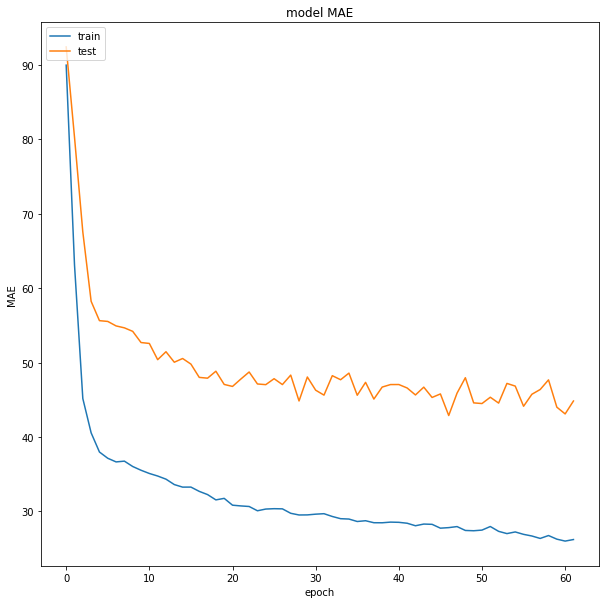

In [59]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_CNN2D.png")




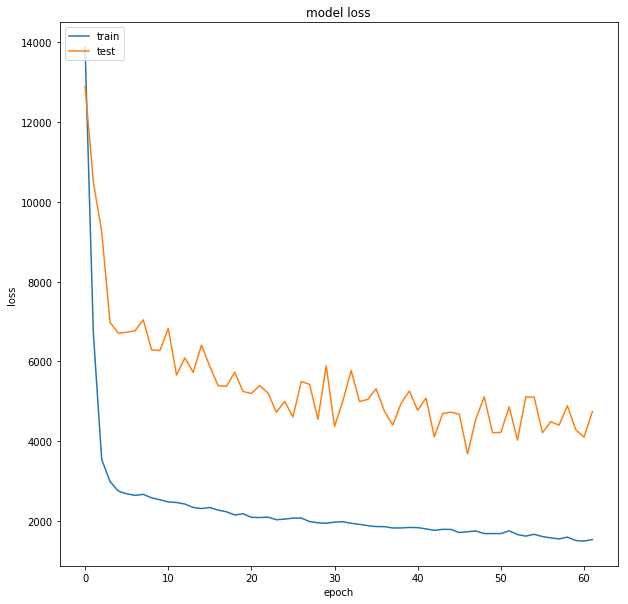

In [60]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_CNN2D_loss.png")

TESTING RESULTS

In [61]:
#label_test_gen = [gen_labels(test_df[test_df['id']==id], sequence_length, ['RUL']) 
#             for id in test_df['id'].unique() if test_df[test_df['id']==id]['cycle'].max()>sequence_length]

In [62]:
#merge labels to form an array of all labels
#y_true = np.concatenate(label_test_gen).astype(np.float32)

In [63]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [[test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]]
                       for id in test_df['id'].unique() if test_df[test_df['id']==id]['cycle'].max()>sequence_length]

seq_array_test_last = np.concatenate(seq_array_test_last).astype(np.float32)

smp=seq_array_test_last.shape[0]
n=seq_array_test_last.shape[2]
seq_array_test_last = seq_array_test_last.reshape(smp, sequence_length, n, 1)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)


# Similarly, we pick the labels
#print("y_mask")
y_mask = [test_df[test_df['id']==id]['cycle'].max()>sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(smp,1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)


MAE: 18.906943492889404


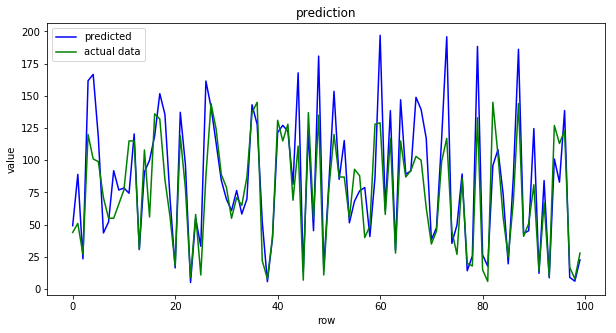

In [64]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))


y_pred_test = model.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_CNN2D_verify.png")

In [65]:
# Using the scoring function

def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp((-d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s

def rmse(true, pred):
    d_squared = (pred - true)**2
    length = len(d_squared)
    err = 0
    for i in range(length):
        err += d_squared[i]
    err = np.sqrt(err/length)
    return err

In [66]:
sf = scoring_function(y_true_test,y_pred_test)
rmse_err = rmse(y_true_test,y_pred_test)

In [67]:
print(sf,rmse_err)

[2000.6403] [26.528358]


In [68]:
#Correlation between the predicted values and actual values
y=[i for sublist in y_true_test for i in sublist]
x=[i for sublist in y_pred_test for i in sublist]

In [69]:
np.corrcoef(y, x)

array([[1.        , 0.86953667],
       [0.86953667, 1.        ]])